objectdetection-chestxray


Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes an image as input and provides a bounding box on the image where an object of interest is found. It also identifies what type of object the box encapsulates. To create such a solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that it can learn about the dataset. Finally, we can then host the trained model in an endpoint, to which we can supply images.




Ground truth process as per following blog:
https://aws.amazon.com/blogs/aws/amazon-sagemaker-ground-truth-build-highly-accurate-datasets-and-reduce-labeling-costs-by-up-to-70/

Documentation for Augmented Mainfest format
https://docs.aws.amazon.com/sagemaker/latest/dg/augmented-manifest.html

Test data downloaded from here:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/data#


In [56]:
import sagemaker
from sagemaker import get_execution_role
 
role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::773208840593:role/my_AmazonSageMakerFullAccess


In [57]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

813361260812.dkr.ecr.eu-central-1.amazonaws.com/object-detection:latest


In [64]:
bucket = 'raz-sagemaker' 
prefix = 'models/object-detection-chest-xray'

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

bucket = 'raz-sagemaker'
prefix = 'annotation/chest_xray/raz-groundtruth-chest-xray-clone-extended-300/manifests/output/output.manifest'
s3_train_data = 's3://{}/{}'.format(bucket, prefix)
print(s3_train_data)

bucket = 'raz-sagemaker'
prefix = 'annotation/chest_xray/validation/raz-groundtruth-chest-xray-clone-validation-extended-42/manifests/output/output.manifest'
s3_validation_data = 's3://{}/{}'.format(bucket, prefix)
print(s3_validation_data)

s3://raz-sagemaker/models/object-detection-chest-xray/output
s3://raz-sagemaker/annotation/chest_xray/raz-groundtruth-chest-xray-clone-extended-300/manifests/output/output.manifest
s3://raz-sagemaker/annotation/chest_xray/validation/raz-groundtruth-chest-xray-clone-validation-extended-42/manifests/output/output.manifest


In [65]:
import numpy as np
import boto3
import tempfile

s3 = boto3.resource('s3', sess.boto_region_name)
bucket = s3.Bucket('raz-sagemaker')
object = bucket.Object('annotation/chest_xray/raz-groundtruth-chest-xray-clone-extended-300/manifests/output/output.manifest')
tmp = tempfile.NamedTemporaryFile()
print(object)

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    
with open(tmp.name) as f:
    num_training_samples = sum(1 for line in f)
    print (num_training_samples)

s3.Object(bucket_name='raz-sagemaker', key='annotation/chest_xray/raz-groundtruth-chest-xray-clone-extended-300/manifests/output/output.manifest')
180


In [69]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=4, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)


The object detection algorithm at its core is the Single-Shot Multi-Box detection algorithm (SSD). This algorithm uses a base_network, which is typically a VGG or a ResNet. The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection documentation for more details on the hyperparameters.

One of the hyperparameters here for instance is the epochs. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only 30 epochs.

Details here: 
https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-api-config.html

In [70]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=16,
                             epochs=300,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=num_training_samples)

In [71]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', content_type='application/x-recordio', s3_data_type='AugmentedManifestFile', attribute_names=['source-ref', 'raz-groundtruth-chest-xray-clone'], record_wrapping='RecordIO')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', content_type='application/x-recordio', s3_data_type='AugmentedManifestFile', attribute_names=['source-ref', 'raz-groundtruth-chest-xray-clone-validation-chain'], record_wrapping='RecordIO')


In [ ]:
data_channels = {'train': train_data, 'validation': validation_data}
print(data_channels)
od_model.fit(inputs=data_channels, logs=True)

{'train': <sagemaker.inputs.s3_input object at 0x7fc7a2d1cef0>, 'validation': <sagemaker.inputs.s3_input object at 0x7fc7a2d1ceb8>}
2020-07-13 20:32:20 Starting - Starting the training job...
2020-07-13 20:32:22 Starting - Launching requested ML instances......
2020-07-13 20:33:27 Starting - Preparing the instances for training......
2020-07-13 20:34:42 Downloading - Downloading input data
2020-07-13 20:34:42 Training - Downloading the training image.

## Deploy Model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the ml.p3.2xlarge instance to train, but we choose to host the model on the less expensive cpu instance, ml.m4.xlarge. The endpoint deployment can be accomplished as follows:

In [49]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

---------------!

## Visualize sample data


s3.Object(bucket_name='raz-sagemaker', key='data/xray/chest_xray/sample/train/IM-0115-0001.jpeg')
/tmp/tmpxiqdapzd


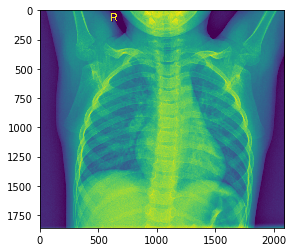

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


import numpy as np
import boto3
import tempfile
 
s3 = boto3.resource('s3', sess.boto_region_name)
bucket = s3.Bucket('raz-sagemaker')
object = bucket.Object('data/xray/chest_xray/sample/train/IM-0115-0001.jpeg')
tmp = tempfile.NamedTemporaryFile()
print(object)
print(tmp.name)

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img=mpimg.imread(tmp.name)
    plt.imshow(img)
    
    
with open(tmp.name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)
    

## Visualize detection
Predict and visualize the bounding box - JSON

In [51]:


import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[0.0, 0.7748507857322693, 0.33771198987960815, 0.3643955588340759, 0.7885932326316833, 0.8008173108100891], [0.0, 0.21323369443416595, 0.11387956142425537, 0.11129021644592285, 0.899105429649353, 0.9206886291503906], [0.0, 0.1742386817932129, 0.9066372513771057, 0.7425593733787537, 1.0, 0.9002688527107239], [0.0, 0.13742780685424805, 0.6788054704666138, 0.0, 1.0, 0.1709185242652893], [0.0, 0.13722698390483856, 0.9076516628265381, 0.6198399662971497, 1.0, 0.7834281325340271], [0.0, 0.13377027213573456, 0.9173333644866943, 0.3759867250919342, 1.0, 0.5236889719963074], [0.0, 0.1299327313899994, 0.9113441109657288, 0.565578818321228, 1.0, 0.7186737060546875], [0.0, 0.12813711166381836, 0.8719862103462219, 0.037159331142902374, 1.0, 0.18503618240356445], [0.0, 0.12453751266002655, 0.24925515055656433, 0.456202894449234, 0.9875234365463257, 1.0], [0.0, 0.12076316028833389, 0.22464796900749207, 0.4163946509361267, 0.710092306137085, 0.6914312243461609], [0.0, 0.119253121316432

## Visualization Helper

The results are in a format that is similar to the input .lst file (See RecordIO Notebook for more details on the .lst file definition. )with an addition of a confidence score for each detected object. The format of the output can be represented as [class_index, confidence_score, xmin, ymin, xmax, ymax]. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [52]:
def visualize_detection(bucket, file, classes=[], thresh=0.6):
        
        
        
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        from PIL import Image


        import numpy as np
        import boto3
        import tempfile

        s3 = boto3.resource('s3', sess.boto_region_name)
        bucket = s3.Bucket(bucket)
        object = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        print(object)
        print(tmp.name)

        with open(tmp.name, 'wb') as f:
            object.download_fileobj(f)
            img=mpimg.imread(tmp.name)
            plt.imshow(img)

        with open(tmp.name, 'rb') as image:
            f = image.read()
            b = bytearray(f)
            ne = open('n.txt','wb')
            ne.write(b)
    
        #Detection
        import json

        object_detector.content_type = 'image/jpeg'
        results = object_detector.predict(b)
        detections = json.loads(results)
        
        dets = detections['prediction']
        img_file = tmp.name

        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

s3.Object(bucket_name='raz-sagemaker', key='data/xray/chest_xray/sample/test/IM-0001-0001.jpeg')
/tmp/tmpgo_qq1dn


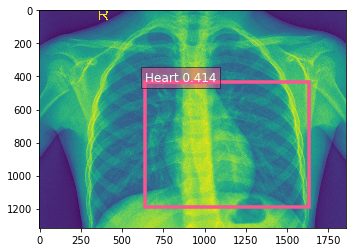

s3.Object(bucket_name='raz-sagemaker', key='data/xray/chest_xray/sample/train/IM-0115-0001.jpeg')
/tmp/tmpyq0pus94


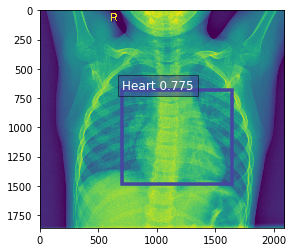

s3.Object(bucket_name='raz-sagemaker', key='data/xray/chest_xray/sample/test/IM-0067-0001.jpeg')
/tmp/tmpl5eak9c5


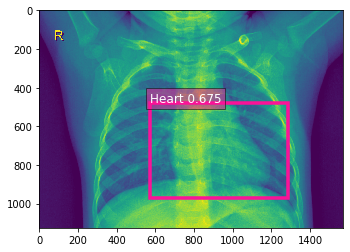

In [54]:
object_categories = ['Heart']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.40

#https://raz-sagemaker.s3.eu-central-1.amazonaws.com/data/xray/chest_xray/sample/test/IM-0001-0001.jpeg
#https://raz-sagemaker.s3.eu-central-1.amazonaws.com/data/xray/chest_xray/sample/test/IM-0033-0001-0002.jpeg
#https://raz-sagemaker.s3.eu-central-1.amazonaws.com/data/xray/chest_xray/sample/test/IM-0067-0001.jpeg
#https://raz-sagemaker.s3.eu-central-1.amazonaws.com/data/xray/chest_xray/sample/train/IM-0115-0001.jpeg

bucket = 'raz-sagemaker'

prefix = 'data/xray/chest_xray/sample/test/IM-0001-0001.jpeg'
visualize_detection(bucket, prefix, object_categories, threshold)

prefix = 'data/xray/chest_xray/sample/train/IM-0115-0001.jpeg'
visualize_detection(bucket, prefix, object_categories, threshold)

prefix = 'data/xray/chest_xray/sample/test/IM-0067-0001.jpeg'
visualize_detection(bucket, prefix, object_categories, threshold)




## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [55]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)